In [ ]:
# Download TorchVision repo to use some files from references/detection
!git clone https://github.com/pytorch/vision.git
!cd kaggle/working/vision
!git checkout v0.8.2

# Copy necessary files
!cp /kaggle/working/vision/references/detection/utils.py /kaggle/working/vision
!cp /kaggle/working/vision/references/detection/transforms.py /kaggle/working/vision
!cp /kaggle/working/vision/references/detection/coco_eval.py /kaggle/working/vision
!cp /kaggle/working/vision/references/detection/engine.py /kaggle/working/vision
!cp /kaggle/working/vision/references/detection/coco_utils.py /kaggle/working/vision


In [ ]:
# !rm -r /kaggle/working/vision

In [ ]:
# !pip install utils

In [1]:
!pip install pycocotools --quiet

In [2]:
import sys

# Add the path to the directory containing engine.py to the module search path
sys.path.append('/kaggle/working/vision')

from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.rpn import AnchorGenerator

from engine import train_one_epoch, evaluate

In [3]:
!pip install wandb --quiet

import wandb
import time
import datetime

In [4]:
from torchvision.ops import box_iou
from torchvision.ops import nms

In [5]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import os

# from engine import train_one_epoch, evaluate

data_folder = '/kaggle/input/malaria-dataset-augmentation-added/organized'

In [6]:
config = {'batch_size': 10,
          'lr': 1e-2,
          'epochs': 100, 
}

**Import Dataset and Create MalariaDataset class**

In [7]:
from PIL import Image
from xml.etree import ElementTree as ET
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms.functional import to_tensor
from torchvision.transforms import transforms

class MalariaDataset(Dataset):
    def __init__(self, root_dir, transform =None):
        self.image_dir = os.path.join(root_dir,'Images')
        self.annot_dir = os.path.join(root_dir, 'Annotations')
        self.transform = transform
        self.image_names = os.listdir(self.image_dir)
        self.image_names.sort()
    
    def __len__(self):
        return len(self.image_names)
    
    def __getitem__(self, idx):
        image_path = os.path.join(self.image_dir, f'image_{idx}.jpg')
        image = Image.open(image_path).convert("RGB")
        image = self.transform(image)
        target = {}
        annot_path = os.path.join(self.annot_dir, f'image_{idx}.xml')
        tree = ET.parse(annot_path)
        root = tree.getroot()
        
        boxes = []
        labels = []
        
        for obj in root.findall('object'):
            label = obj.find('name').text
            if label == 'PF':
                labels.append(1)
            elif label == 'PV':
                labels.append(2)
            elif label == 'PM':
                labels.append(3)
            elif label == 'PO':
                labels.append(4)
            bndbox = obj.find('bndbox')
            xmin = int(bndbox.find('xmin').text)
            ymin = int(bndbox.find('ymin').text)
            xmax = int(bndbox.find('xmax').text)
            ymax = int(bndbox.find('ymax').text)

            boxes.append([xmin, ymin, xmax, ymax])
            
        
        boxes = torch.tensor(boxes, dtype=torch.float32)
        labels = torch.tensor(labels)
        target['boxes'] = boxes
        target['labels'] = labels
        
        ######
#         image_id = torch.tensor([idx])
        image_id = idx

        target["image_id"] = image_id
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        iscrowd = torch.zeros((boxes.shape[0],), dtype=torch.int64)
        target["area"] = area
        target["iscrowd"] = iscrowd
        ######
        
        return image, target
    
    
collate_fn = lambda batch: tuple(zip(*batch))
        
train_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean = [0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])
    
        
dataset = MalariaDataset(data_folder, transform=train_transforms)
dataloader = DataLoader(dataset, batch_size=32, shuffle=True, num_workers=4, collate_fn=collate_fn)

        

/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [8]:
img, target = next(iter(dataloader))
print(img[0].shape)
print(target[0])

torch.Size([3, 640, 640])
{'boxes': tensor([[177., 524., 222., 579.],
        [222.,  33., 258.,  77.]]), 'labels': tensor([4, 4]), 'image_id': 1110, 'area': tensor([2475., 1584.]), 'iscrowd': tensor([0, 0])}


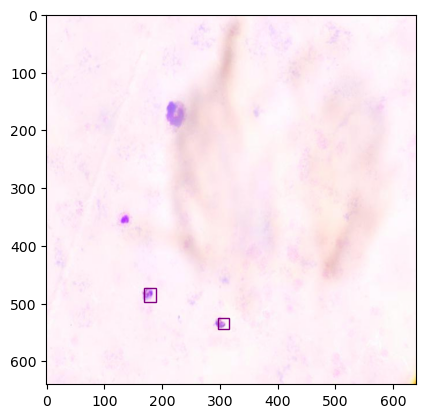

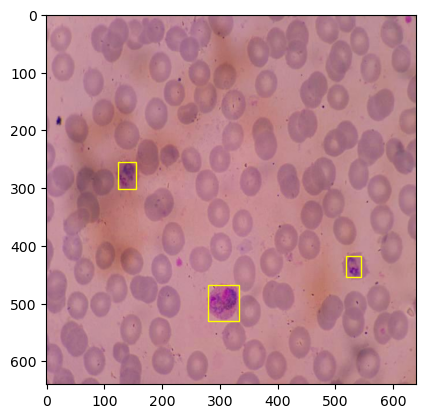

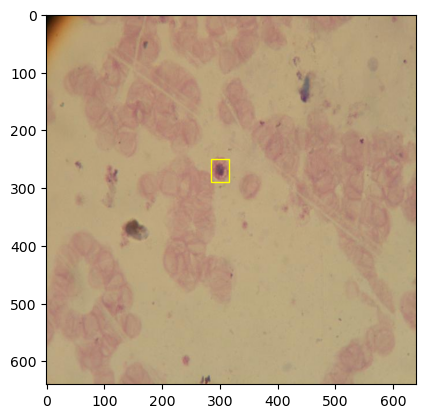

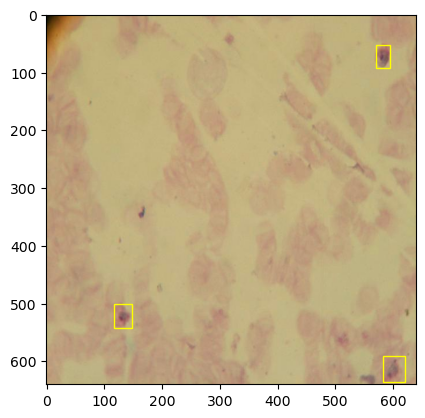

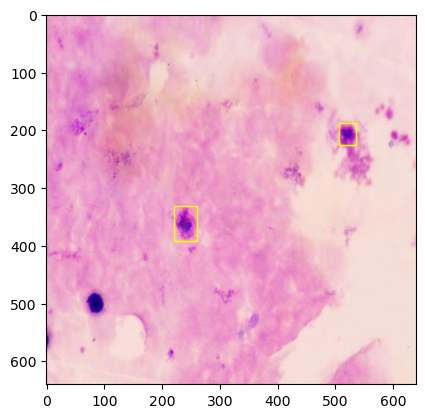

In [9]:
from matplotlib import pyplot as plt
from matplotlib import patches

class UnNormalize(object):
    def __init__(self, mean, std):
        self.mean = mean
        self.std = std

    def __call__(self, tensor):
        """
        Args:
            tensor (Tensor): Tensor image of size (C, H, W) to be normalized.
        Returns:
            Tensor: Normalized image.
        """
        for t, m, s in zip(tensor, self.mean, self.std):
            t.mul_(s).add_(m)
            # The normalize code -> t.sub_(m).div_(s)
        return tensor
    
unorm = UnNormalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))


def display_image(image, targets, dataset):
    fig, ax = plt.subplots(1)
    # Unnormalize the input image and convert it to a numpy array
    unnormalized_image = unorm(image).cpu().permute(1, 2, 0).numpy()
#     unnormalized_image = image.cpu().permute(1, 2, 0).numpy()
    ax.imshow(unnormalized_image)
    boxes = targets['boxes']
    labels = targets['labels']
    label_color = ['green', 'red', 'purple','yellow' ]
    label_names = ['PF','PV', 'PM', 'PO']
    for j, box in enumerate(boxes):
        xmin, ymin, xmax, ymax = box
#         rect = patches.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin, linewidth=2, edgecolor=label_color[labels[j] - 1], facecolor='none')
        rect = patches.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin, linewidth=1, edgecolor=label_color[labels[j]-1], facecolor='none')

        ax.add_patch(rect)
#         ax.text(xmin, ymin - 10, label_names[labels[j] - 1], fontsize=8, color='r')

    plt.show() 

for i, batch in enumerate(dataloader):
    if i == 3: # display images from the 4th batch

        for j in range(len(batch[0])):
            image = batch[0][j]
            targets = batch[1][j]
            display_image(image, targets, dataset)
            if j==4:
                break

In [10]:
# Randomly split data into train part and test part
train_data_ratio = 0.70

train_size = int(len(dataset) * train_data_ratio)
test_size = len(dataset) - train_size # test data shouldn't be appeared in training

train_data, test_data = torch.utils.data.random_split(dataset, [train_size, test_size])

print("Train data size: ", len(train_data))
print("Test data size: ", len(test_data))

Train data size:  1035
Test data size:  444


In [11]:
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

# Define the model
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
# model = torchvision.models.detection.fasterrcnn_mobilenet_v3_large_fpn(pretrained=True)

# model = torchvision.models.detection.fasterrcnn_resnet50_fpn(weights="DEFAULT")



/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


## **VGG-16 model**

In [ ]:
# !pip install torchvision --quiet

In [ ]:
from torchvision.models.detection.anchor_utils import AnchorGenerator
from torchvision.models.detection import FasterRCNN

import torchvision

vgg16 = torchvision.models.vgg16(weights="DEFAULT")
backbone = vgg16.features

backbone.out_channels = 512

anchor_generator = AnchorGenerator()

roi_pooler = torchvision.ops.MultiScaleRoIAlign(featmap_names= ['0'], output_size=7, sampling_ratio=2)

vgg16_model = FasterRCNN(backbone, num_classes=5, rpn_anchor_generator=anchor_generator, box_roi_pool=roi_pooler)

model = vgg16_model

In [ ]:
# num_classes = 5
# in_features = model.roi_heads.box_predictor.cls_score.in_features
# model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)


In [12]:
# Define the optimizer and learning rate scheduler
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.AdamW(params, lr=config['lr'],
                              amsgrad=True, 
                              weight_decay=1e-6)
# optimizer = torch.optim.SGD(params, lr=config['lr'], weight_decay=0.0005)

# and a learning rate scheduler
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer,
                                               step_size=10,
                                               gamma=0.5)
# lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer)

# Define the device (GPU or CPU)
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

## **Save on Wandb**

In [ ]:
wandb.login(key="Pass your key here") 


In [ ]:
run = wandb.init(
    name = "Faster_R-CNN_vgg-16-Sep6-AdamW-batch-4-test", ## Wandb creates random run names if you skip this field
    reinit = True, ### Allows reinitalizing runs when you re-run this cell
#     id = "vgtv2ni8",### Insert specific run id here if you want to resume a previous run
#     resume = "must", ### You need this to resume previous runs, but comment out reinit = True when using this
    project = "Malaria-Project", ### Project should be created in your wandb account 
    config = config ### Wandb Config for your run
)


In [ ]:
# # Comment the code below to use the imported library and uncomment to use this training loop

# # Define the training loop
# def train_one_epoch(model, optimizer, data_loader, device, epoch, print_freq):
#     model.train()

#     for batch_idx, (images, targets) in enumerate(data_loader):
#         # Sending training data to CUDA
#         images = list([image.to(device) for image in images])
#         targets = [{k: v.to(device) for k, v in t.items()} for t in targets]   
#         loss_dict = model(images, targets)
#         losses = sum(loss for loss in loss_dict.values())
#         optimizer.zero_grad()
#         losses.backward()
#         optimizer.step()
#         if batch_idx % print_freq == 0:
#             print(f'Epoch: {epoch}, Batch: {batch_idx}, Loss: {losses}')

## **Load Model from a checkpoint**

In [15]:
state_dict = torch.load('/kaggle/working/checkpoint_ResNet-scratch-sep3-SGD_all_data.pth')
model.load_state_dict(state_dict['model_state_dict'])
# optimizer.load_state_dict(state_dict['optimizer_state_dict'])
lr_scheduler.load_state_dict(state_dict['scheduler_state_dict'])

In [ ]:
# print(model.parameters().__next__().device)

In [ ]:
torch.cuda.empty_cache()

In [ ]:
# !rm -r /kaggle/working/checkpoint_MobileNet-sep4-AdamW_batch10.pth

##  **Start the training loop**

In [14]:
# Define the number of epochs and batch size
num_epochs = config['epochs']
dataloader = DataLoader(train_data, batch_size=config['batch_size'], shuffle=True, num_workers=4, collate_fn=collate_fn)
dataloader_test = DataLoader(test_data, batch_size=config['batch_size'], shuffle=False, num_workers=4, collate_fn=collate_fn)

# Train the model
model.to(device)

t_tot = 0
map_init = 0

for epoch in range(num_epochs):
    
    curr_lr = float(optimizer.param_groups[0]['lr'])
    
    start_time = time.time()
    metric_logger  = train_one_epoch(model, optimizer, dataloader, device, epoch, print_freq = 20)
    lr_scheduler.step()
    
    
    epoch_time = time.time() - start_time
    t_tot += epoch_time
#     print(f"[{str(datetime.timedelta(seconds = epoch_time))[2:7]}]")
    print(f"Epoch {epoch + 1} - Time: [{str(datetime.timedelta(seconds=epoch_time))[2:7]}] - Total Time: [{str(datetime.timedelta(seconds=t_tot))[2:7]}]")

    test_accuracy = evaluate(model, dataloader_test, device=device)
    print("Test_Accuracy", test_accuracy.coco_eval['bbox'].stats[1],test_accuracy.coco_eval['bbox'].stats[8] )

    mAP = test_accuracy.coco_eval['bbox'].stats[1]
    
    wandb.log({
    "loss_classifier": metric_logger.loss_classifier.value, 
    "loss_box_reg": metric_logger.loss_box_reg.value, 
    "loss_rpn_box_reg": metric_logger.loss_rpn_box_reg.value, 
    "loss_objectness": metric_logger.loss_objectness.value, 
    "loss": metric_logger.loss.value, 
    "learning_Rate": curr_lr,
    "mAP@0.5_IOU" : test_accuracy.coco_eval['bbox'].stats[1],
    "recall" : test_accuracy.coco_eval['bbox'].stats[8]
})

    print("Saving model")
    
    if(mAP > map_init):
        map_init = mAP
        
        torch.save({'model_state_dict':model.state_dict(),
                    'optimizer_state_dict':optimizer.state_dict(),
                    'scheduler_state_dict':lr_scheduler.state_dict(),
                    'loss_classifier': metric_logger.loss_classifier, 
                    'loss_box_reg' :  metric_logger.loss_box_reg,
                    'loss_rpn_box_reg': metric_logger.loss_rpn_box_reg,
                    'loss_objectness' : metric_logger.loss_objectness,
                    'loss' : metric_logger.loss,
                    'epoch': epoch}, '/kaggle/working/checkpoint_Vgg-16-sep6-AdamW_batch4_test.pth')
    
    
    wandb.save('/kaggle/working/checkpoint_vgg-16-sep5-AdamW_batch4_test.pth')
    
run.finish()

Epoch: [0]  [  0/104]  eta: 0:08:31  lr: 0.000107  loss: 0.2233 (0.2233)  loss_classifier: 0.0663 (0.0663)  loss_box_reg: 0.1445 (0.1445)  loss_objectness: 0.0041 (0.0041)  loss_rpn_box_reg: 0.0084 (0.0084)  time: 4.9166  data: 1.1353  max mem: 8409


KeyboardInterrupt: 

In [ ]:
# %%writefile /kaggle/working/vision/coco_utils.py
# import os

# import torch
# import torch.utils.data
# import torchvision
# import transforms as T
# from pycocotools import mask as coco_mask
# from pycocotools.coco import COCO


# def convert_coco_poly_to_mask(segmentations, height, width):
#     masks = []
#     for polygons in segmentations:
#         rles = coco_mask.frPyObjects(polygons, height, width)
#         mask = coco_mask.decode(rles)
#         if len(mask.shape) < 3:
#             mask = mask[..., None]
#         mask = torch.as_tensor(mask, dtype=torch.uint8)
#         mask = mask.any(dim=2)
#         masks.append(mask)
#     if masks:
#         masks = torch.stack(masks, dim=0)
#     else:
#         masks = torch.zeros((0, height, width), dtype=torch.uint8)
#     return masks


# class ConvertCocoPolysToMask:
#     def __call__(self, image, target):
#         w, h = image.size

#         image_id = target["image_id"]

#         anno = target["annotations"]

#         anno = [obj for obj in anno if obj["iscrowd"] == 0]

#         boxes = [obj["bbox"] for obj in anno]
#         # guard against no boxes via resizing
#         boxes = torch.as_tensor(boxes, dtype=torch.float32).reshape(-1, 4)
#         boxes[:, 2:] += boxes[:, :2]
#         boxes[:, 0::2].clamp_(min=0, max=w)
#         boxes[:, 1::2].clamp_(min=0, max=h)

#         classes = [obj["category_id"] for obj in anno]
#         classes = torch.tensor(classes, dtype=torch.int64)

#         segmentations = [obj["segmentation"] for obj in anno]
#         masks = convert_coco_poly_to_mask(segmentations, h, w)

#         keypoints = None
#         if anno and "keypoints" in anno[0]:
#             keypoints = [obj["keypoints"] for obj in anno]
#             keypoints = torch.as_tensor(keypoints, dtype=torch.float32)
#             num_keypoints = keypoints.shape[0]
#             if num_keypoints:
#                 keypoints = keypoints.view(num_keypoints, -1, 3)

#         keep = (boxes[:, 3] > boxes[:, 1]) & (boxes[:, 2] > boxes[:, 0])
#         boxes = boxes[keep]
#         classes = classes[keep]
#         masks = masks[keep]
#         if keypoints is not None:
#             keypoints = keypoints[keep]

#         target = {}
#         target["boxes"] = boxes
#         target["labels"] = classes
#         target["masks"] = masks
#         target["image_id"] = image_id
#         if keypoints is not None:
#             target["keypoints"] = keypoints

#         # for conversion to coco api
#         area = torch.tensor([obj["area"] for obj in anno])
#         iscrowd = torch.tensor([obj["iscrowd"] for obj in anno])
#         target["area"] = area
#         target["iscrowd"] = iscrowd

#         return image, target


# def _coco_remove_images_without_annotations(dataset, cat_list=None):
#     def _has_only_empty_bbox(anno):
#         return all(any(o <= 1 for o in obj["bbox"][2:]) for obj in anno)

#     def _count_visible_keypoints(anno):
#         return sum(sum(1 for v in ann["keypoints"][2::3] if v > 0) for ann in anno)

#     min_keypoints_per_image = 10

#     def _has_valid_annotation(anno):
#         # if it's empty, there is no annotation
#         if len(anno) == 0:
#             return False
#         # if all boxes have close to zero area, there is no annotation
#         if _has_only_empty_bbox(anno):
#             return False
#         # keypoints task have a slight different criteria for considering
#         # if an annotation is valid
#         if "keypoints" not in anno[0]:
#             return True
#         # for keypoint detection tasks, only consider valid images those
#         # containing at least min_keypoints_per_image
#         if _count_visible_keypoints(anno) >= min_keypoints_per_image:
#             return True
#         return False

#     ids = []
#     for ds_idx, img_id in enumerate(dataset.ids):
#         ann_ids = dataset.coco.getAnnIds(imgIds=img_id, iscrowd=None)
#         anno = dataset.coco.loadAnns(ann_ids)
#         if cat_list:
#             anno = [obj for obj in anno if obj["category_id"] in cat_list]
#         if _has_valid_annotation(anno):
#             ids.append(ds_idx)

#     dataset = torch.utils.data.Subset(dataset, ids)
#     return dataset


# def convert_to_coco_api(ds):
#     coco_ds = COCO()
#     # annotation IDs need to start at 1, not 0, see torchvision issue #1530
#     ann_id = 1
#     dataset = {"images": [], "categories": [], "annotations": []}
#     categories = set()
#     for img_idx in range(len(ds)):
#         # find better way to get target
#         # targets = ds.get_annotations(img_idx)
#         img, targets = ds[img_idx]
#         image_id = targets["image_id"]
#         img_dict = {}
#         img_dict["id"] = image_id
#         img_dict["height"] = img.shape[-2]
#         img_dict["width"] = img.shape[-1]
#         dataset["images"].append(img_dict)
#         bboxes = targets["boxes"].clone()
#         bboxes[:, 2:] -= bboxes[:, :2]
#         bboxes = bboxes.tolist()
#         labels = targets["labels"].tolist()
#         areas = targets["area"].tolist()
#         iscrowd = targets["iscrowd"].tolist()
#         if "masks" in targets:
#             masks = targets["masks"]
#             # make masks Fortran contiguous for coco_mask
#             masks = masks.permute(0, 2, 1).contiguous().permute(0, 2, 1)
#         if "keypoints" in targets:
#             keypoints = targets["keypoints"]
#             keypoints = keypoints.reshape(keypoints.shape[0], -1).tolist()
#         num_objs = len(bboxes)
#         for i in range(num_objs):
#             ann = {}
#             ann["image_id"] = image_id
#             ann["bbox"] = bboxes[i]
#             ann["category_id"] = labels[i]
#             categories.add(labels[i])
#             ann["area"] = areas[i]
#             ann["iscrowd"] = iscrowd[i]
#             ann["id"] = ann_id
#             if "masks" in targets:
#                 ann["segmentation"] = coco_mask.encode(masks[i].numpy())
#             if "keypoints" in targets:
#                 ann["keypoints"] = keypoints[i]
#                 ann["num_keypoints"] = sum(k != 0 for k in keypoints[i][2::3])
#             dataset["annotations"].append(ann)
#             ann_id += 1
#     dataset["categories"] = [{"id": i} for i in sorted(categories)]
#     coco_ds.dataset = dataset
#     coco_ds.createIndex()
#     return coco_ds


# def get_coco_api_from_dataset(dataset):
#     # FIXME: This is... awful?
#     for _ in range(10):
#         if isinstance(dataset, torchvision.datasets.CocoDetection):
#             break
#         if isinstance(dataset, torch.utils.data.Subset):
#             dataset = dataset.dataset
#     if isinstance(dataset, torchvision.datasets.CocoDetection):
#         return dataset.coco
#     return convert_to_coco_api(dataset)


# class CocoDetection(torchvision.datasets.CocoDetection):
#     def __init__(self, img_folder, ann_file, transforms):
#         super().__init__(img_folder, ann_file)
#         self._transforms = transforms

#     def __getitem__(self, idx):
#         img, target = super().__getitem__(idx)
#         image_id = self.ids[idx]
#         target = dict(image_id=image_id, annotations=target)
#         if self._transforms is not None:
#             img, target = self._transforms(img, target)
#         return img, target


# def get_coco(root, image_set, transforms, mode="instances", use_v2=False, with_masks=False):
#     anno_file_template = "{}_{}2017.json"
#     PATHS = {
#         "train": ("train2017", os.path.join("annotations", anno_file_template.format(mode, "train"))),
#         "val": ("val2017", os.path.join("annotations", anno_file_template.format(mode, "val"))),
#         # "train": ("val2017", os.path.join("annotations", anno_file_template.format(mode, "val")))
#     }

#     img_folder, ann_file = PATHS[image_set]
#     img_folder = os.path.join(root, img_folder)
#     ann_file = os.path.join(root, ann_file)

#     if use_v2:
#         from torchvision.datasets import wrap_dataset_for_transforms_v2

#         dataset = torchvision.datasets.CocoDetection(img_folder, ann_file, transforms=transforms)
#         target_keys = ["boxes", "labels", "image_id"]
#         if with_masks:
#             target_keys += ["masks"]
#         dataset = wrap_dataset_for_transforms_v2(dataset, target_keys=target_keys)
#     else:
#         # TODO: handle with_masks for V1?
#         t = [ConvertCocoPolysToMask()]
#         if transforms is not None:
#             t.append(transforms)
#         transforms = T.Compose(t)

#         dataset = CocoDetection(img_folder, ann_file, transforms=transforms)

#     if image_set == "train":
#         dataset = _coco_remove_images_without_annotations(dataset)

#     # dataset = torch.utils.data.Subset(dataset, [i for i in range(500)])

#     return dataset


In [ ]:
# ###### import torchvision.ops as ops
# # Load a single minibatch of data
# # test_dataloader = DataLoader(test_data, batch_size=4, shuffle=False, num_workers=4, collate_fn=collate_fn)

# images, targets = next(iter(dataloader_test))



# print("Image Length",len(test_dataloader))
# print("Image Length",len(images))

# # Run the model on the minibatch of images
# model.eval()
# with torch.no_grad():
#     images = list([image.to(device) for image in images])
#     outputs = model(images)
    
#     print("Length" , len(images))

#     for i, image in enumerate(images):
#         # Extract the predicted bounding boxes and labels for the current image
#         boxes = outputs[i]['boxes'].cpu().numpy()
#         scores = outputs[i]['scores'].cpu().numpy()
#         labels = outputs[i]['labels'].cpu().numpy()
    
#         print("labels", labels)
#         print("scores", scores)

#         # Visualize the input image with the predicted bounding boxes and labels
#         fig, ax = plt.subplots(1)
#         ax.imshow(unorm(image).cpu().permute(1, 2, 0))
#         label_color = ['green', 'red', 'purple', 'yellow' ]
#         label_names = ['PF','PV', 'PM', 'PO']
        
#         valid_indices = scores > 0.3
#         valid_boxes = boxes[valid_indices]
#         valid_labels = labels[valid_indices]
#         valid_scores = scores[valid_indices]
        

# #         for box, label, score in zip(boxes, labels, scores):
# #             x1, y1, x2, y2 = box.astype(np.int)
# #             ax.add_patch(plt.Rectangle((x1, y1), x2-x1, y2-y1, fill=False, edgecolor=label_color[label - 1], linewidth=1))
# #             ax.text(x1, y1 - 10, label_names[label - 1] + ': ' + str(score*100) + '%', fontsize=8, color='r')

#         for box, label, score in zip(valid_boxes, valid_labels, valid_scores):
#             x1, y1, x2, y2 = box.astype(np.int)
#             ax.add_patch(plt.Rectangle((x1, y1), x2 - x1, y2 - y1, fill=False, edgecolor=label_color[label - 1], linewidth=1))
#             ax.text(x1, y1 - 10, label_names[label - 1] + ': ' + str(score) + '%', fontsize=8, color='r')


#         plt.show()

## **New Code for drawing the bounding box**

In [16]:
def filterBoxes(output,nms_th=0.3,score_threshold=0.5):
    
    boxes = output['boxes']
    scores = output['scores']
    labels = output['labels']
    
    # Non Max Supression
    mask = nms(boxes,scores,nms_th)
    
    boxes = boxes[mask]
    scores = scores[mask]
    labels = labels[mask]
    
    boxes = boxes.data.cpu().numpy().astype(np.int32)
    scores = scores.data.cpu().numpy()
    labels = labels.data.cpu().numpy()
    
    mask = scores >= score_threshold
    boxes = boxes[mask]
    scores = scores[mask]
    labels = labels[mask]
    
    return boxes, scores, labels


def displayPredictions(image,output,nms_th=0.3,score_threshold=0.5):
    boxes,scores,labels = filterBoxes(output,nms_th,score_threshold)
    
    fig, ax = plt.subplots(1)
    ax.imshow(unorm(image).cpu().permute(1, 2, 0))
    label_color = ['green', 'red', 'purple', 'yellow' ]
    label_names = ['PF','PV', 'PM', 'PO']
    
    for box, label, score in zip(boxes, labels, scores):
        x1, y1, x2, y2 = box.astype(np.int)
        ax.add_patch(plt.Rectangle((x1, y1), x2 - x1, y2 - y1, fill=False, edgecolor=label_color[label - 1], linewidth=1))
        ax.text(x1, y1 - 10, label_names[label - 1] + ': ' + str(round(score*100,3)) + '%', fontsize=8, color='r')


    plt.show()
  

In [23]:
dataloader_test = DataLoader(test_data, batch_size=30, shuffle=False, num_workers=4, collate_fn=collate_fn)


Length 30


/tmp/ipykernel_794/4144062040.py:35: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  x1, y1, x2, y2 = box.astype(np.int)


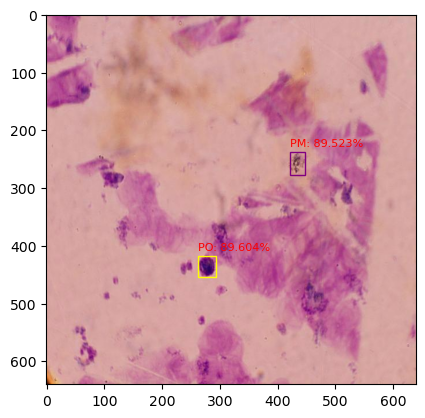

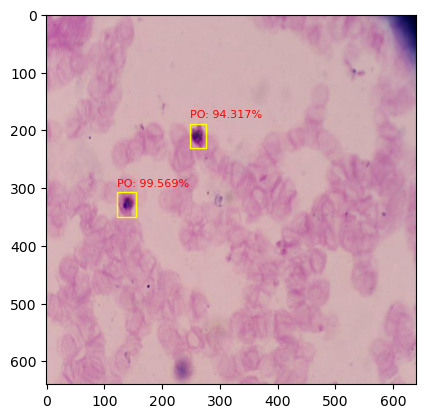

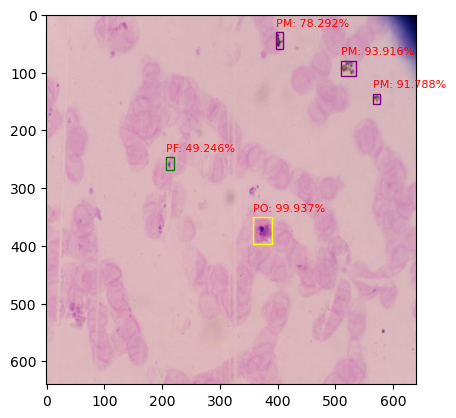

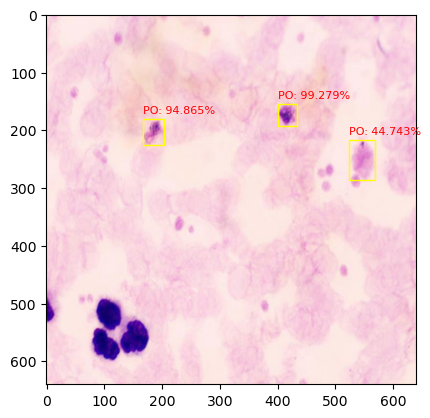

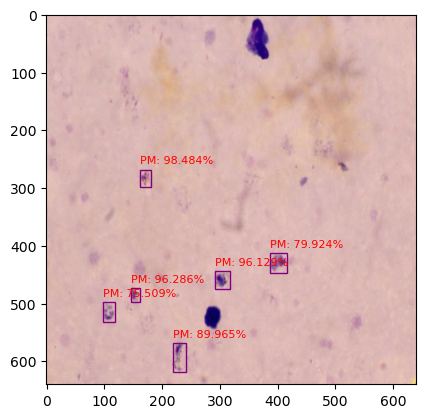

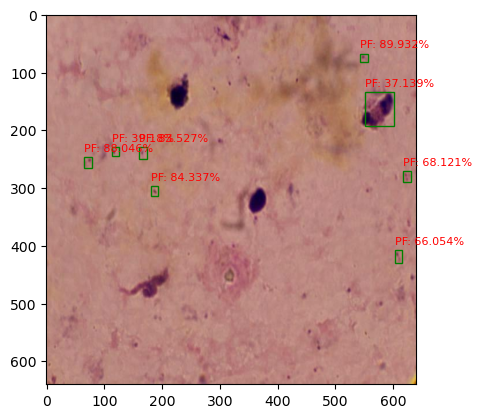

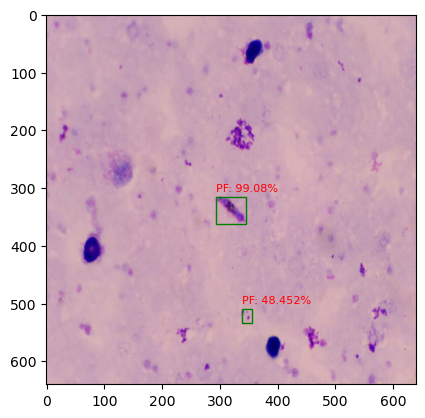

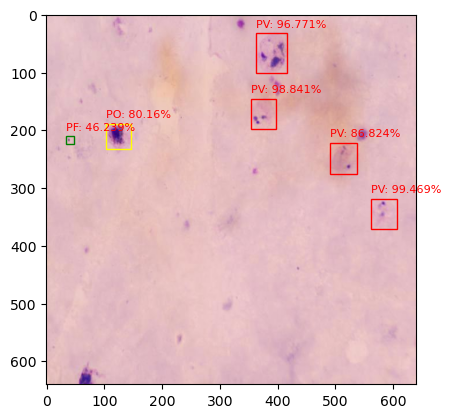

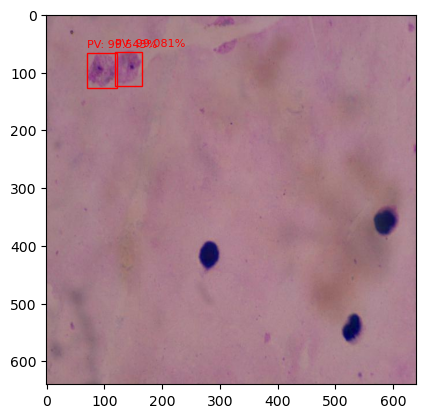

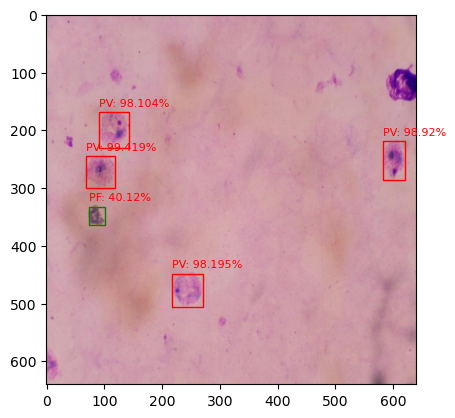

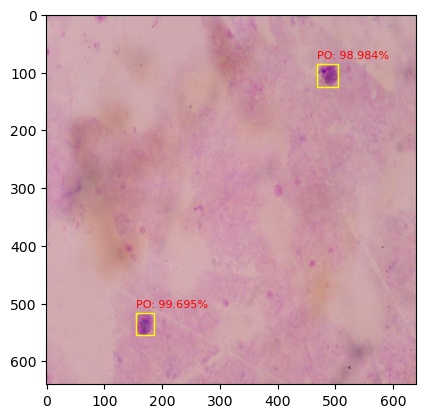

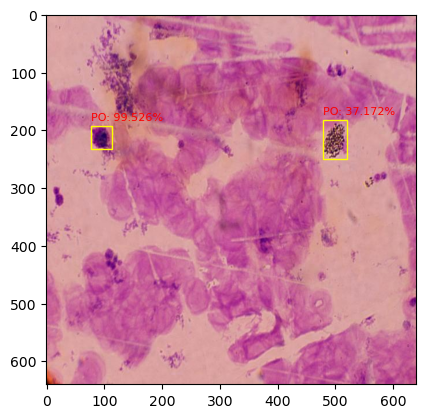

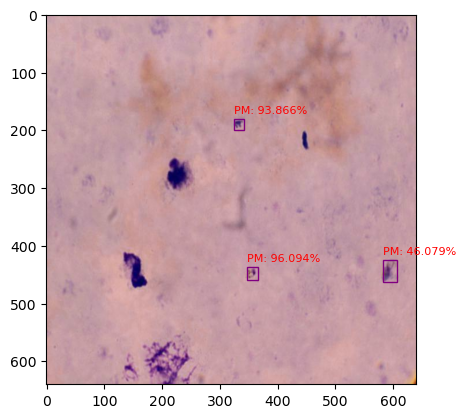

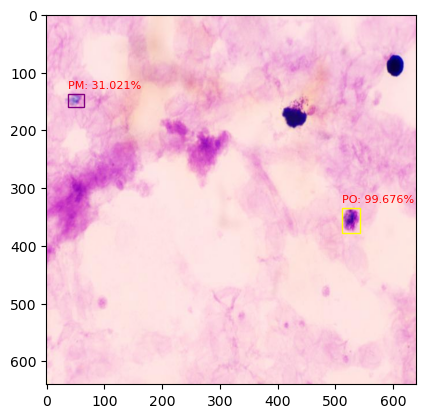

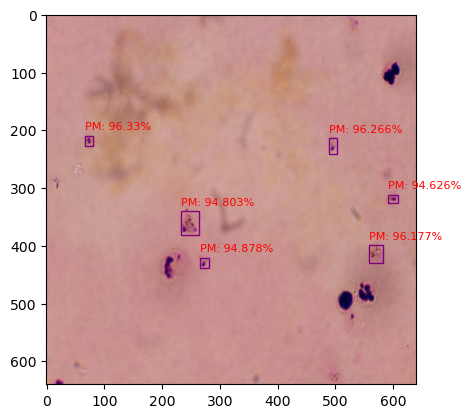

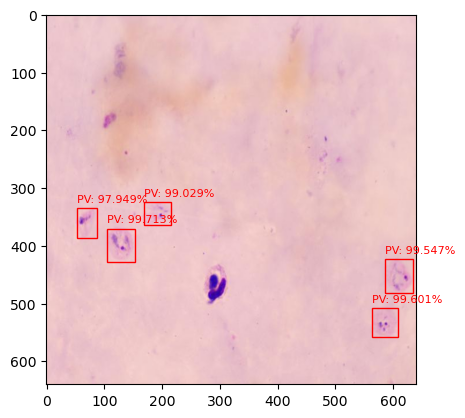

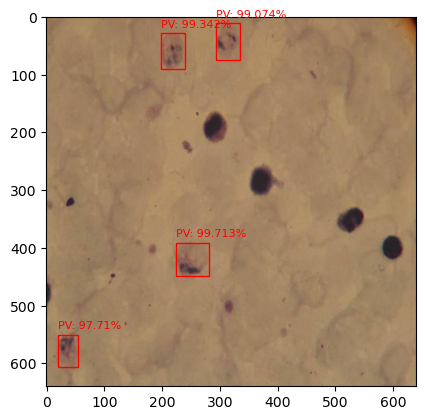

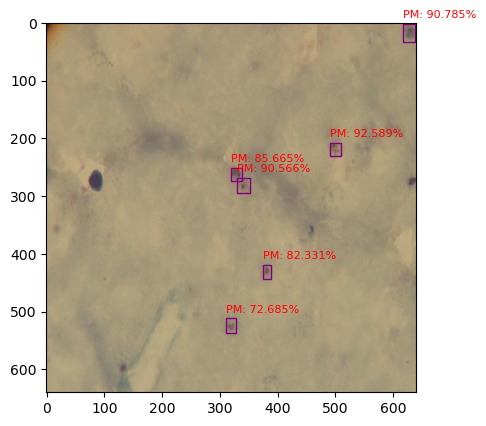

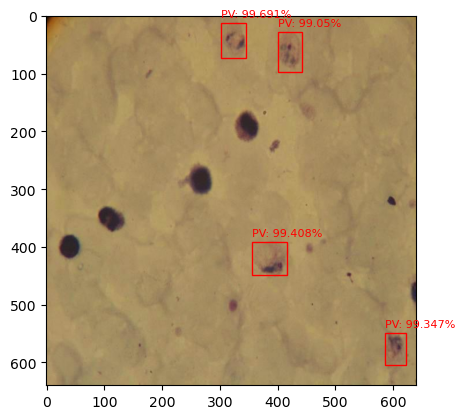

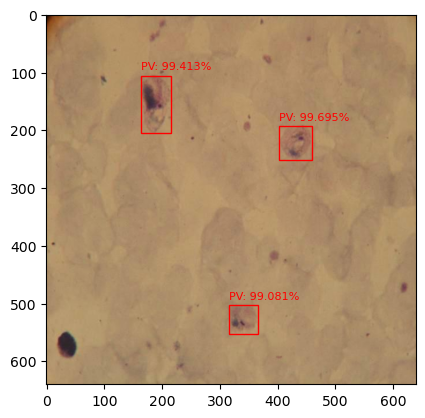

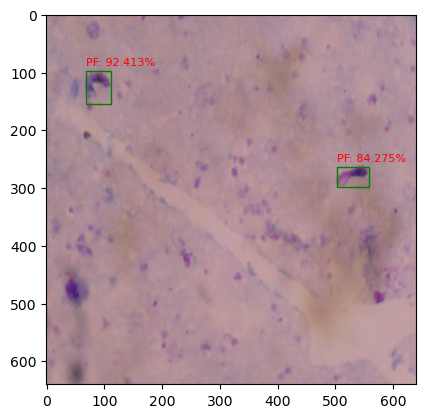

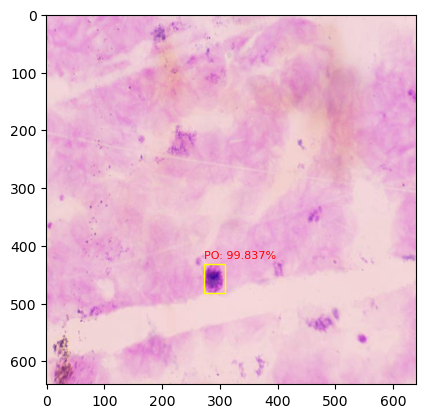

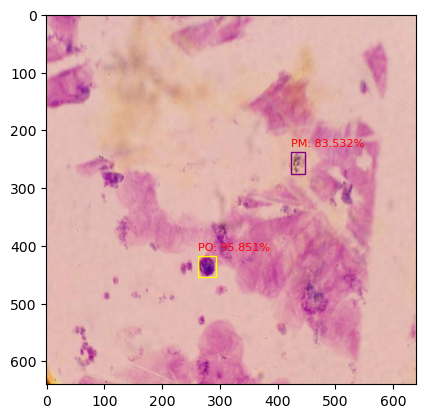

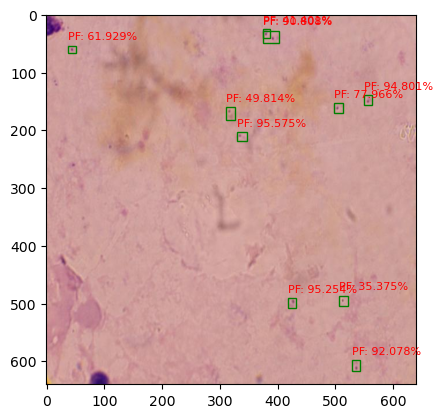

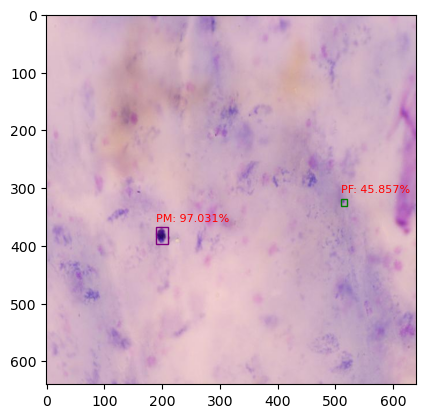

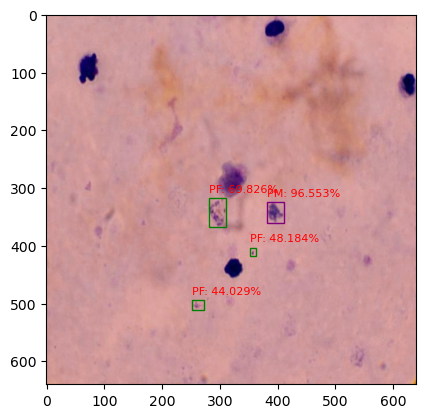

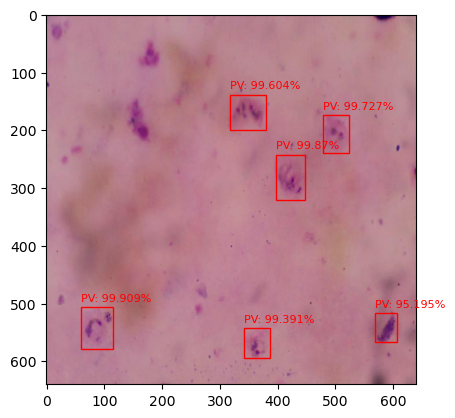

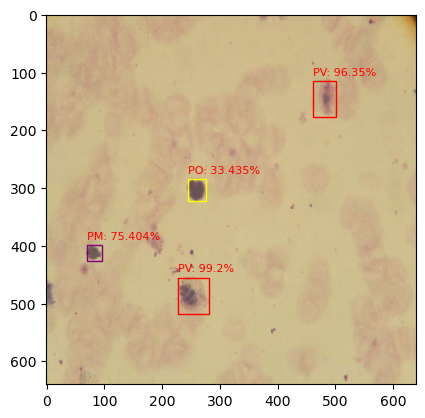

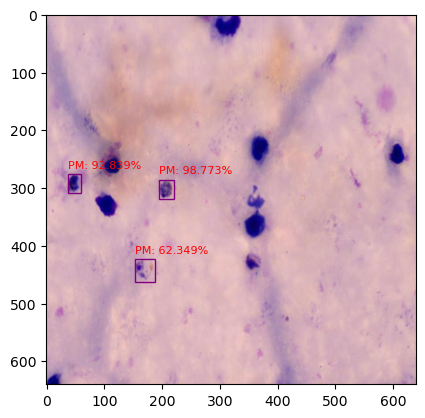

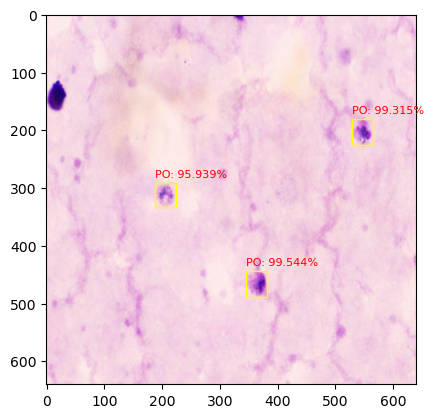

In [24]:
images, targets = next(iter(dataloader_test))
# for _ in range(3):  # Advance the iterator to the 3rd batch
#     images, targets = next(iter(dataloader_test))




model.eval()
torch.cuda.empty_cache()

with torch.no_grad():
    images = list([image.to(device) for image in images])
    outputs = model(images)
    
    print("Length" , len(images))

    for i, image in enumerate(images):
        
        displayPredictions(images[i],outputs[i],0.3, 0.3)
    

## **IOU and Evaluation claculation**

In [ ]:
def iou(box1, box2):
    """
    Calculate intersection over union (IoU) between two bounding boxes with a format of [xmin, ymin, xmax, ymax]
    """

    xi1 = max(box1[0], box2[0])
    yi1 = max(box1[1], box2[1])
    xi2 = min(box1[2], box2[2])
    yi2 = min(box1[3], box2[3])
    inter_area = max(xi2 - xi1, 0) * max(yi2 - yi1, 0)
    
    box1_area = (box1[2] - box1[0]) * (box1[3] - box1[1])
    box2_area = (box2[2] - box2[0]) * (box2[3] - box2[1])
    union_area = box1_area + box2_area - inter_area

#     assert iou >= 0
    
    return inter_area / union_area

def calculate_image_ap(gt_boxes, pred_boxes, iou_threshold):
    """
    Calculate average precision for a single image
    """
    pred_boxes = sorted(pred_boxes, key=lambda x: x[1], reverse=True)

    gt_used = [False] * len(gt_boxes)
    tp, fp = [], []

    for pred_box in pred_boxes:
        matched_gt = -1
        for idx, gt_box in enumerate(gt_boxes):
            if gt_used[idx]:
                continue
            if iou(pred_box[0], gt_box[0]) > iou_threshold:
                matched_gt = idx
                break
        if matched_gt >= 0:
            tp.append(1)
            gt_used[matched_gt] = True
        else:
            tp.append(0)
        fp.append(1 - tp[-1])
    
    tp = np.cumsum(tp).tolist()
    fp = np.cumsum(fp).tolist()

    precisions = [tp[i] / (tp[i] + fp[i]) for i in range(len(tp))]
    recalls = [tp[i] / len(gt_boxes) for i in range(len(tp))]

    precisions = [0.] + precisions + [0.]
    recalls = [0.] + recalls + [1.]

    for i in range(len(precisions) - 2, -1, -1):
        precisions[i] = max(precisions[i], precisions[i + 1])

    ap = 0.
    for i in range(1, len(precisions)):
        if recalls[i] != recalls[i - 1]:
            ap += (recalls[i] - recalls[i - 1]) * precisions[i]
    return ap

def calculate_map(gt_boxes_list, pred_boxes_list, iou_threshold):
    """
    Calculate mean average precision for a list of images
    """
    ap_list = [calculate_image_ap(gt_boxes, pred_boxes, iou_threshold) for gt_boxes, pred_boxes in zip(gt_boxes_list, pred_boxes_list)]
    
    print("ap_list", ap_list)
    
    return sum(ap_list) / len(ap_list)

In [ ]:
def predict(data_loader, model):
    device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
    model.eval().to(device)
    i = 0
    
    actuals = []
    predicts = []
    for images, targets in data_loader:
        if torch.cuda.is_available():
            torch.cuda.synchronize()
        image = list(img.to(device) for img in images)
        
        outputs = model(image)
        
        target_boxes = targets[0]['boxes'].detach().cpu().numpy().tolist()
        
        scores = outputs[0]['scores'].detach().cpu().numpy().tolist()
        boxes = outputs[0]['boxes'].detach().cpu().numpy().tolist()
        pred_boxes = [[bbox, score] for bbox, score in zip(boxes, scores)]
        
        actuals.append([target_boxes])
        predicts.append(pred_boxes)
       
    return actuals, predicts

In [ ]:
test_dataloader = DataLoader(test_data, batch_size=4, shuffle=False, num_workers=4, collate_fn=collate_fn)


In [ ]:
actuals, predicts = predict(test_dataloader, model)

In [ ]:
print("mAP: ", calculate_map(actuals, predicts, 0.5))

In [ ]:
# import numpy as np
# import torch
# from sklearn.metrics import confusion_matrix, f1_score, accuracy_score, recall_score

# def calculate_iou(box1, box2):
#     """
#     Calculate intersection over union (IoU) between two bounding boxes with a format of [xmin, ymin, xmax, ymax]
#     """

#     xi1 = max(box1[0], box2[0])
#     yi1 = max(box1[1], box2[1])
#     xi2 = min(box1[2], box2[2])
#     yi2 = min(box1[3], box2[3])
#     inter_area = max(xi2 - xi1, 0) * max(yi2 - yi1, 0)
    
#     box1_area = (box1[2] - box1[0]) * (box1[3] - box1[1])
#     box2_area = (box2[2] - box2[0]) * (box2[3] - box2[1])
#     union_area = box1_area + box2_area - inter_area
    
#     return inter_area / union_area

# def calculate_metrics(actuals, predicts, iou_threshold):
#     gt_boxes_list = actuals
#     pred_boxes_list = predicts
#     ap_list = [calculate_image_ap(gt_boxes, pred_boxes, iou_threshold) for gt_boxes, pred_boxes in zip(gt_boxes_list, pred_boxes_list)]
#     mean_ap = sum(ap_list) / len(ap_list)
    
#     # Calculate additional metrics
#     y_true = []
#     y_pred = []
#     for actual_boxes, pred_boxes in zip(gt_boxes_list, pred_boxes_list):
#         y_true.append(len(actual_boxes) > 0)
#         y_pred.append(len(pred_boxes) > 0)
    
#     accuracy = accuracy_score(y_true, y_pred)
#     recall = recall_score(y_true, y_pred)
#     f1 = f1_score(y_true, y_pred)
    
#     conf_matrix = confusion_matrix(y_true, y_pred)
    
#     return mean_ap, recall, accuracy, f1, conf_matrix

# def predict_and_calculate_metrics(data_loader, model, iou_threshold):
#     device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
#     model.eval().to(device)
    
#     actuals = []
#     predicts = []
#     for images, targets in data_loader:
#         if torch.cuda.is_available():
#             torch.cuda.synchronize()
#         image = list(img.to(device) for img in images)
        
#         outputs = model(image)
        
#         target_boxes = targets[0]['boxes'].detach().cpu().numpy().tolist()
        
#         scores = outputs[0]['scores'].detach().cpu().numpy().tolist()
#         boxes = outputs[0]['boxes'].detach().cpu().numpy().tolist()
#         pred_boxes = [[bbox, score] for bbox, score in zip(boxes, scores)]
        
#         actuals.append(target_boxes)
#         predicts.append(pred_boxes)
       
#     return calculate_metrics(actuals, predicts, iou_threshold)

# test_dataloader = DataLoader(test_data, batch_size=4, shuffle=False, num_workers=4, collate_fn=collate_fn)

# iou_threshold = 0.5
# mAP, recall, accuracy, f1, conf_matrix = predict_and_calculate_metrics(test_dataloader, model, iou_threshold)

# print("mAP:", mAP)
# print("Recall:", recall)
# print("Accuracy:", accuracy)
# print("F1 Score:", f1)
# print("Confusion Matrix:")
# print(conf_matrix)


## **Evaluation Added on the above code -  There could be error**

In [ ]:
from torchvision.ops import box_iou

test_dataloader = DataLoader(test_data, batch_size=4, shuffle=False, num_workers=4, collate_fn=collate_fn)


model.eval()
total_precision = 0.0
total_recall = 0.0
total_iou = 0.0
total_images = 0

with torch.no_grad():
    for images, targets in test_dataloader:
        images = list(image.to(device) for image in images)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        outputs = model(images)

        for i, target in enumerate(targets):
            predicted_boxes = outputs[i]['boxes']
            predicted_scores = outputs[i]['scores']
            predicted_labels = outputs[i]['labels']

            true_boxes = target['boxes']
            true_labels = target['labels']

            iou = box_iou(predicted_boxes, true_boxes)
            max_iou, _ = iou.max(dim=1)

            true_positive = (max_iou > 0.3) & (predicted_labels == true_labels[:, None])
            false_positive = (max_iou < 0.3) & (predicted_labels != 0)

            true_positive_count = true_positive.sum().item()
            false_positive_count = false_positive.sum().item()

            if true_positive_count + false_positive_count > 0:
                precision = true_positive_count / (true_positive_count + false_positive_count)
            else:
                precision = 0.0

            if len(true_labels) > 0:
                recall = true_positive_count / len(true_labels)
            else:
                recall = 0.0
            total_precision += precision
            total_recall += recall
            total_iou += max_iou.sum().item()
            total_images += 1

precision = total_precision / total_images
recall = total_recall / total_images
average_iou = total_iou / total_images

print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"Average IoU: {average_iou:.4f}")


## ****The ground truth Images****

In [ ]:
for i, batch in enumerate(test_dataloader):
    if i == 0 : # display images from the 4th batch

        for j in range(len(batch[0])):
            image = batch[0][j]
            targets = batch[1][j]
            display_image(image, targets, dataset)
            if j==4:
                break